# 0.0 Set Up

## 1.0 Imports - !pip install <package_name> if necessary

In [2]:
import pandas as pd
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics.pairwise import linear_kernel
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

import numpy as np
from tqdm.auto import tqdm


In [3]:
nltk.download('stopwords')
nltk.download('wordnet')  # For lemmatization

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 0.1 Helper Functions

In [4]:
def load_json_data(file_path):
    with open(file_path, "r") as file:
        contents = json.load(file)
    return contents


def create_tfidf_matrix(citing_dataset, nonciting_dataset, vectorizer=TfidfVectorizer()):
    """
    Creates TF-IDF matrix for the given citing and non-citing datasets based on the specified text column.

    Parameters:
    citing_dataset (json)): DataFrame containing citing patents.
    nonciting_dataset (json): DataFrame containing non-citing patents.
    vectorizer (TfidfVectorizer, optional): TfidfVectorizer object for vectorizing text data.
                                             Defaults to TfidfVectorizer().

    Returns:
    tuple: A tuple containing TF-IDF matrices for citing and non-citing patents respectively.
           (tfidf_matrix_citing, tfidf_matrix_nonciting)
    """
    all_text = [patent['text'] for patent in citing_dataset + nonciting_dataset]

    # Vectorizing descriptions
    print("Vectorizing descriptions...")
    tfidf_matrix = vectorizer.fit_transform(tqdm(all_text, desc="TF-IDF"))

    # Since we're interested in similarities between citing and cited patents,
    # we need to split the TF-IDF matrix back into two parts
    split_index = len(citing_dataset)
    tfidf_matrix_citing = tfidf_matrix[:split_index]
    tfidf_matrix_nonciting = tfidf_matrix[split_index:]

    # Size of vocabulary
    print("Size of vocabulary:", len(vectorizer.vocabulary_))

    return tfidf_matrix_citing, tfidf_matrix_nonciting



def get_mapping_dict(mapping_df):
    """
    Creates dictionary of citing ids to non-citing id based on given dataframe (which is based on providedjson)

    Parameters:
    mapping_df (DataFrame): DataFrame containing mapping between citing and cited patents
    Returns:
    dict: dictionary of unique citing patent ids to list of cited patent ids
    """
    mapping_dict = {}

    for _, row in mapping_df.iterrows():
        key = row[0]  # Value from column 0
        value = row[2]  # Value from column 2
        if key in mapping_dict:
            mapping_dict[key].append(value)
        else:
            mapping_dict[key] = [value]

    return mapping_dict

def create_corpus(corpus, text_type):
    """
    Extracts text data from a corpus based on the specified text type.

    Parameters:
    corpus (list): List of dictionaries representing patent documents.
    text_type (str): Type of text to extract ('title', 'abstract', 'claim1', 'claims', 'description', 'fulltext').

    Returns:
    list: List of dictionaries with 'id' and 'text' keys representing each document in the corpus.
    """

    app_ids = [doc['Application_Number'] + doc['Application_Category'] for doc in corpus]

    cnt = 0 # count the number of documents without text
    texts = []  # list of texts
    ids_to_remove = []  # list of ids of documents without text, to remove them from the corpus

    if text_type == 'title':
        for doc in corpus:
            try:
                texts.append(doc['Content']['title'])
            except: # if the document does not have a title
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
        print(f"Number of documents without title: {cnt}")

    elif text_type == 'abstract':
        for doc in corpus:
            try:
                texts.append(doc['Content']['pa01'])
            except: # if the document does not have an abstract
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
        print(f"Number of documents without abstract: {cnt}")

    elif text_type == 'claim1':
        for doc in corpus:
            try:
                texts.append(doc['Content']['c-en-0001'])
            except: # if the document does not have claim 1
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
        print(f"Number of documents without claim 1: {cnt}")

    elif text_type == 'claims':
        # all the values with the key starting with 'c-en-', each element in the final list is a list of claims
        for doc in corpus:
            doc_claims = []
            for key in doc['Content'].keys():
                if key.startswith('c-en-'):
                    doc_claims.append(doc['Content'][key])
            if len(doc_claims) == 0:    # if the document does not have any claims
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
            else:
                doc_text_string = ' '.join(doc_claims)
                texts.append(doc_text_string)
        print(f"Number of documents without claims: {cnt}")

    elif text_type == 'description':
        # all the values with the key starting with 'p'
        for doc in corpus:
            doc_text = []
            for key in doc['Content'].keys():
                if key.startswith('p'):
                    doc_text.append(doc['Content'][key])
            if len(doc_text) == 0:  # if the document does not have any description
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
            else:
                doc_text_string = ' '.join(doc_text)
                texts.append(doc_text_string)
        print(f"Number of documents without description: {cnt}")

    elif text_type == 'fulltext':
        for doc in corpus:
            doc_text = list(doc['Content'].values())
            doc_text_string = ' '.join(doc_text)
            texts.append(doc_text_string)
        if cnt > 0:
            print(f"Number of documents without any text: {cnt}")

    else:
        raise ValueError("Invalid text type")

    if len(ids_to_remove) > 0:
        print(f"Removing {len(ids_to_remove)} documents without required text")
        for id_ in ids_to_remove[::-1]:
            idx = app_ids.index(id_)
            del app_ids[idx]

    # Create a list of dictionaries with app_ids and texts
    corpus_data = [{'id': app_id, 'text': text} for app_id, text in zip(app_ids, texts)]

    return corpus_data


def get_true_and_predicted(citing_to_cited_dict, recommendations_dict):
    """
    Get the true and predicted labels for the metrics calculation.

    Parameters:
    citing_to_cited_dict : dict of str : list of str
        Mapping between citing patents and the list of their cited patents
    recommendations_dict : dict of str : list of str
        Mapping between citing patents and the sorted list of recommended patents

    Returns:
    list of list
        True relevant items for each recommendation list.
    list of list
        Predicted recommended items for each recommendation list.
    int
        Number of patents not in the citation mapping
    """
    # Initialize lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []
    not_in_citation_mapping = 0

    # Iterate over the items in both dictionaries
    for citing_id in recommendations_dict.keys():
        # Check if the citing_id is present in both dictionaries
        if citing_id in citing_to_cited_dict:
            # If yes, append the recommended items from both dictionaries to the respective lists
            true_labels.append(citing_to_cited_dict[citing_id])
            predicted_labels.append(recommendations_dict[citing_id])
        else:
            not_in_citation_mapping += 1

    return true_labels, predicted_labels, not_in_citation_mapping



def mean_recall_at_k(true_labels, predicted_labels, k=10):
    """
    Calculate the mean Recall@k for a list of recommendations.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.
    k : int
        Number of recommendations to consider.

    Returns:
    float
        Mean Recall@k value.
    """
    recalls_at_k = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate Recall@k for each recommendation list
        true_set = set(true)
        k = min(k, len(pred))
        relevant_count = sum(1 for item in pred[:k] if item in true_set)
        recalls_at_k.append(relevant_count / len(true_set))

    # Calculate the mean Recall@k
    mean_recall = sum(recalls_at_k) / len(recalls_at_k)

    return mean_recall

def mean_inv_ranking(true_labels, predicted_labels):
    """
    Calculate the mean of lists of the mean inverse rank of true relevant items
    in the lists of sorted recommended items.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.

    Returns:
    float
        Mean of lists of the mean inverse rank of true relevant items.
    """
    mean_ranks = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate the inverse rank of true relevant items
        # in the recommendation list
        ranks = []
        for item in true:
            try:
                rank = 1 / (pred.index(item) + 1)
            except ValueError:
                rank = 0  # If item not found, assign 0
            ranks.append(rank)

        # Calculate the mean inverse rank of true relevant items
        # in the recommendation list
        mean_rank = sum(ranks) / len(ranks)
        mean_ranks.append(mean_rank)

    # Calculate the mean of the mean inverse ranks across all recommendation lists
    mean_of_mean_ranks = sum(mean_ranks) / len(mean_ranks)

    return mean_of_mean_ranks


def mean_ranking(true_labels, predicted_labels):
    """
    Calculate the mean of lists of the mean rank of true relevant items
    in the lists of sorted recommended items.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.

    Returns:
    float
        Mean of lists of the mean rank of true relevant items.
    """
    mean_ranks = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate the rank of true relevant items
        # in the recommendation list
        ranks = []
        for item in true:
            try:
                rank = pred.index(item) + 1
            except ValueError:
                rank = len(pred)  # If item not found, assign the length of the list
            ranks.append(rank)

        # Calculate the mean rank of true relevant items
        # in the recommendation list
        mean_rank = sum(ranks) / len(ranks)
        mean_ranks.append(mean_rank)

    # Calculate the mean of the mean ranks across all recommendation lists
    mean_of_mean_ranks = sum(mean_ranks) / len(mean_ranks)

    return mean_of_mean_ranks



def mean_average_precision(true_labels, predicted_labels, k=10):
    """
    Calculate the mean Average Precision for a list of recommendations.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.
    k : int
        Number of recommendations to consider.

    Returns:
    float
        Mean Average Precision value.
    """
    average_precisions = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate Average Precision for each recommendation list
        true_set = set(true)
        precision_at_k = []
        relevant_count = 0
        for i, item in enumerate(pred[:k]):
            if item in true_set:
                relevant_count += 1
                precision_at_k.append(relevant_count / (i + 1))
        average_precision = sum(precision_at_k) / len(true_set)
        average_precisions.append(average_precision)

    # Calculate the mean Average Precision
    mean_average_precision = sum(average_precisions) / len(average_precisions)

    return mean_average_precision

def top_k_ranks(citing, cited, cosine_similarities, k=10):
    # Create a dictionary to store the top k ranks for each citing patent
    top_k_ranks = {}
    for i, content_id in enumerate(citing):
        top_k_ranks[content_id['id']] = [cited[j]['id'] for j in np.argsort(cosine_similarities[i])[::-1][:k]]
    return top_k_ranks


# 1.0 Load Datasets

In [5]:
!gzip datasets.tar
!tar -xvzf datasets.tar.gz

tar (child): datasets.tar: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [8]:
json_citing_train = load_json_data("./datasets/Content_JSONs/Citing_2020_Cleaned_Content_12k/Citing_Train_Test/citing_TRAIN.json")
json_citing_test = load_json_data("./datasets/Content_JSONs/Citing_2020_Cleaned_Content_12k/Citing_Train_Test/citing_TEST.json")

json_nonciting = load_json_data("./datasets/Content_JSONs/Cited_2020_Uncited_2010-2019_Cleaned_Content_22k/CLEANED_CONTENT_DATASET_cited_patents_by_2020_uncited_2010-2019.json")
json_citing_to_cited = load_json_data("./datasets/Citation_JSONs/Citation_Train.json") # Citing ids are unique

In [9]:
citing_dataset_df = pd.DataFrame(json_citing_train)

nonciting_dataset_df = pd.DataFrame(json_nonciting)
mapping_dataset_df = pd.DataFrame(json_citing_to_cited)

In [10]:
citing_dataset_df

,Application_Number,Application_Date,Application_Category,Content
0,3650293,2020-05-13,A1,{'title': 'DEVICE FOR CONTROLLING THE BRAKING ...
1,3694265,2020-08-12,A1,{'title': 'TIME DIVISION MULTIPLEXING OF SYNCH...
2,3623522,2020-03-18,A1,{'title': 'LAUNDRY MACHINE AND CONTROL METHOD ...
3,3611147,2020-02-19,A1,{'title': 'CHEMICAL AND TOPOLOGICAL SURFACE MO...
4,3640454,2020-04-22,A1,"{'title': 'FUEL METERING SYSTEM', 'pa01': 'The..."
...,...,...,...,...
6826,3741587,2020-11-25,A1,{'title': 'AUTO-LOCATION USING TIRE MOUNTED SY...
6827,3693248,2020-08-12,A1,{'title': 'HOLE COVER AND STEERING SYSTEM INCL...
6828,3628962,2020-04-01,A1,{'title': 'SYSTEM AND METHOD FOR MEASURING CLE...
6829,3620899,2020-03-11,A1,{'title': 'TOUCH SCREEN AND DISPLAY APPARATUS'...


In [11]:
nonciting_dataset_df

,Application_Number,Application_Date,Application_Category,Content
0,2019772,2013-08-28,B1,"{'title': 'VEHICLE WITH LOCKABLE TILT SYSTEM',..."
1,2136094,2013-05-22,B1,"{'title': 'UNIVERSAL JOINT', 'c-en-0001': 'A u..."
2,2340701,2011-07-06,A2,"{'title': 'Apparatus, method and computer prog..."
3,2338661,2011-06-29,A1,{'title': 'Method and apparatus for forming a ...
4,2339144,2011-06-29,A2,{'title': 'Heat exchanger mounting assembly in...
...,...,...,...,...
16832,1995910,2012-07-11,B1,"{'title': 'Synchronization of a split audio, v..."
16833,1997557,2012-02-08,B1,{'title': 'Fluid handling unit and fluid handl...
16834,1992846,2012-04-04,B1,"{'title': 'Oil pump system for vehicle', 'c-en..."
16835,1981195,2012-01-11,B1,{'title': 'Apparatus for construction of quasi...


In [12]:
mapping_dataset_df

,0,1,2,3,4
0,3712070A1,[c-en-0004],3354576A1,"[p0024, p0027, c-en-0012, c-en-0013]",A
1,3675165A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3336831A2,"[p0045, p0046, p0047, p0048, p0049, p0050, p00...",A
2,3599626A1,"[c-en-0002, c-en-0003, c-en-0004, c-en-0005, c...",2453448A1,"[p0029, p0030]",A
3,3705201A1,"[c-en-0001, c-en-0002, c-en-0004, c-en-0006, c...",2468433A2,"[p0011, p0012, p0013, p0014, p0015, p0016, p00...",X
4,3628210A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3369366A1,[pa01],A
...,...,...,...,...,...
8589,3623977A1,"[c-en-0008, c-en-0009, c-en-0010, c-en-0011, c...",2518981A1,"[p0021, p0022, p0023, p0024, p0025, p0026, p00...",A
8590,3721843A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3213727A1,"[p0015, p0016, p0017, p0018, p0019, p0020, p00...",X
8591,3708263A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3217171A1,"[pa01, p0010, p0014, p0003, p0009, p0016]",A
8592,3588557A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",2988328A1,"[p0047, p0012]",A


In [13]:
mapping_dict = get_mapping_dict(mapping_dataset_df)
mapping_dict

{'3712070A1': ['3354576A1'],
 '3675165A1': ['3336831A2'],
 '3599626A1': ['2453448A1'],
 '3705201A1': ['2468433A2'],
 '3628210A1': ['3369366A1'],
 '3637504A1': ['2482368A1'],
 '3758169A1': ['2575411A1'],
 '3597767A1': ['2226127A1'],
 '3588532A1': ['2879156A1'],
 '3670817A1': ['3231978A1'],
 '3702079A1': ['3338931A1'],
 '3668068A1': ['3116204A1'],
 '3750631A1': ['3132851A1'],
 '3599082A1': ['2730353A1'],
 '3587089A1': ['3028845A1'],
 '3605854A1': ['3319239A1'],
 '3607862A1': ['2815685A1'],
 '3742402A1': ['3361724A2'],
 '3705896A1': ['2743710A1'],
 '3587065A1': ['2689910A1'],
 '3739813A1': ['2584496A1'],
 '3624050A1': ['2887642A2'],
 '3719445A1': ['2778606A1'],
 '3599363A1': ['3486467A2'],
 '3747742A1': ['2783951A1'],
 '3742709A1': ['3101560A1'],
 '3667442A1': ['2808242A1'],
 '3670124A1': ['2826608A1'],
 '3715223A1': ['2815953A1'],
 '3686680A1': ['3435167A1'],
 '3723272A1': ['3076542A1'],
 '3674167A1': ['2447130A1'],
 '3689738A1': ['3263446A1'],
 '3606117A1': ['3267699A1'],
 '3670347A1': 

In [32]:
#import ast
#nonciting_dataset_df['all_content'] = nonciting_dataset_df['Content'].apply(ast.literal_eval)

## 1.1 Take a look at the content

In [15]:
nonciting_dataset_df.loc[0].Content

{'title': 'VEHICLE WITH LOCKABLE TILT SYSTEM',
 'c-en-0001': 'A vehicle support assembly, comprising: first and second tilting wheels (421A, 421B; 16, 16) disposed respectively at different lateral positions with respect to a longitudinal axis; a tilt-mechanism (431; 17) configured for supportively associating a vehicle body (402) from the tilting wheels (421A, 421B; 16, 16) to enable the vehicle body (402) to tilt substantially through a first tilt range with respect to a surface (428) on which the tilting wheels (421A, 421B; 16, 16) are disposed; a tilt-limiter (450, 550, 650) operably associated with the tilt-mechanism (431) to restrict the tilting of the vehicle body (402) to less than the first tilt range, and releasable to allow the tilting through the first tilt range; characterised in that the vehicle support assembly further comprises : an inclination sensor configured to sense an inclination of the vehicle (130, 430) with respect to the vertical at least when the vehicle is a

## 1.2 Create a column with the Title

Note for lateR: Try all text content by uncommenting the below

In [34]:
#import ast
#nonciting_dataset_df['all_content'] = nonciting_dataset_df['Content'].apply(ast.literal_eval)

In [17]:
def extract_title(dictionary):
    return dictionary.get('title', None)  # Return None if 'title' key is not present

nonciting_dataset_df['Title'] = nonciting_dataset_df['Content'].apply(extract_title)
citing_dataset_df['Title'] = citing_dataset_df['Content'].apply(extract_title)

nonciting_dataset_df

,Application_Number,Application_Date,Application_Category,Content,Title
0,2019772,2013-08-28,B1,"{'title': 'VEHICLE WITH LOCKABLE TILT SYSTEM',...",VEHICLE WITH LOCKABLE TILT SYSTEM
1,2136094,2013-05-22,B1,"{'title': 'UNIVERSAL JOINT', 'c-en-0001': 'A u...",UNIVERSAL JOINT
2,2340701,2011-07-06,A2,"{'title': 'Apparatus, method and computer prog...","Apparatus, method and computer program product..."
3,2338661,2011-06-29,A1,{'title': 'Method and apparatus for forming a ...,Method and apparatus for forming a rubber article
4,2339144,2011-06-29,A2,{'title': 'Heat exchanger mounting assembly in...,Heat exchanger mounting assembly in a gas turbine
...,...,...,...,...,...
16832,1995910,2012-07-11,B1,"{'title': 'Synchronization of a split audio, v...","Synchronization of a split audio, video, or ot..."
16833,1997557,2012-02-08,B1,{'title': 'Fluid handling unit and fluid handl...,Fluid handling unit and fluid handling apparat...
16834,1992846,2012-04-04,B1,"{'title': 'Oil pump system for vehicle', 'c-en...",Oil pump system for vehicle
16835,1981195,2012-01-11,B1,{'title': 'Apparatus for construction of quasi...,Apparatus for construction of quasi orthogonal...


# 1.3 Average title length

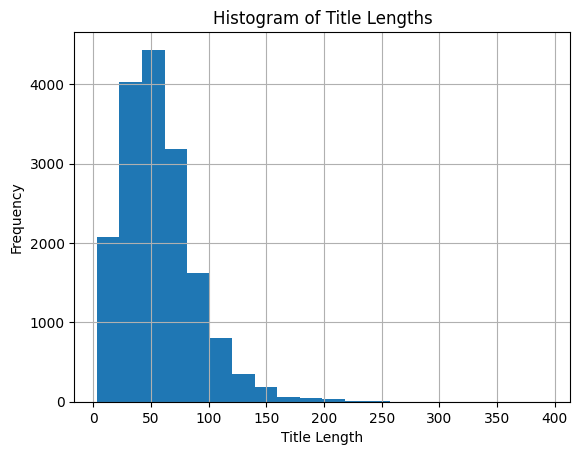

In [18]:
plt.hist(nonciting_dataset_df['Title'].str.len(), bins=20)
plt.xlabel('Title Length')
plt.ylabel('Frequency')
plt.title('Histogram of Title Lengths')
plt.grid(True)
plt.show()


## 1.3 Number of CITED patents per citing patent

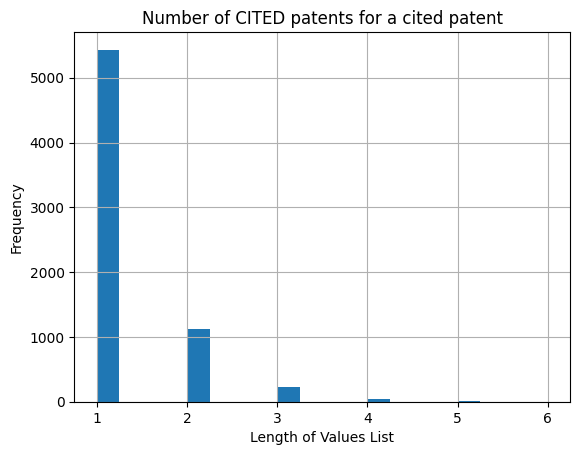

In [19]:
list_lengths = [len(values) for values in mapping_dict.values()]

plt.hist(list_lengths, bins=20)
plt.xlabel('Length of Values List')
plt.ylabel('Frequency')
plt.title('Number of CITED patents for a cited patent')
plt.grid(True)
plt.show()


# 2.0 TF-IDF

## 2.1 'Title' TF-IDF

Let's consider only the Title text for now

In [20]:
# Load the title of the citing and cited patents, create_corpus creates a dictionary of 'id' : 'title' for each patent.
title_citing_train = create_corpus(json_citing_train , 'title')
title_citing_test = create_corpus(json_citing_test , 'title')

title_nonciting = create_corpus(json_nonciting, 'title')
title_citing_train[:5]

Number of documents without title: 0
Number of documents without title: 0
Number of documents without title: 0


[{'id': '3650293A1',
  'text': 'DEVICE FOR CONTROLLING THE BRAKING OF A TRAILER'},
 {'id': '3694265A1',
  'text': 'TIME DIVISION MULTIPLEXING OF SYNCHRONIZATION CHANNELS'},
 {'id': '3623522A1', 'text': 'LAUNDRY MACHINE AND CONTROL METHOD OF THE SAME'},
 {'id': '3611147A1',
  'text': 'CHEMICAL AND TOPOLOGICAL SURFACE MODIFICATION TO ENHANCE COATING ADHESION AND COMPATIBILITY'},
 {'id': '3640454A1', 'text': 'FUEL METERING SYSTEM'}]

### 2.1.1 Initalize TF-IDF

In [21]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)

tfidf_citing, tfidf_nonciting = create_tfidf_matrix(title_citing_train, title_nonciting, tfidf_vectorizer)

print(f"Shape of citing TF-IDF matrix: {tfidf_citing.shape}")
print(f"Shape of citedTF-IDF matrix: {tfidf_nonciting.shape}")

Vectorizing descriptions...


TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Size of vocabulary: 10000
Shape of citing TF-IDF matrix: (6831, 10000)
Shape of citedTF-IDF matrix: (16837, 10000)


### 2.1.2 Get Cosine similarities

In [22]:
cosine_similarities = linear_kernel(tfidf_citing, tfidf_nonciting)
cosine_similarities

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.16696119, ..., 0.        , 0.        ,
        0.03522194],
       ...,
       [0.        , 0.        , 0.01757464, ..., 0.        , 0.        ,
        0.01505416],
       [0.        , 0.        , 0.06885372, ..., 0.        , 0.0532077 ,
        0.05897901],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### 2.1.3 Get Metrics

In [23]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(title_citing_train, title_nonciting, cosine_similarities, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)

recall_at_10_titles_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_titles_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_titles_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_titles_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_titles_tfidf, 4))
print("Recall at 20:", round(recall_at_20_titles_tfidf, 4))
print("Recall at 50:", round(recall_at_50_titles_tfidf, 4))
print("Recall at 100:", round(recall_at_100_titles_tfidf, 4))
print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.2572
Recall at 20: 0.318
Recall at 50: 0.4034
Recall at 100: 0.4692
Mean ranking: 62.3638
Mean average precision: 0.1528
Number of patents measured: 6831
Number of patents not in the citation: 0


## 2.2 'Claim1' TF-IDF

In [24]:
# Load the title of the citing and cited patents, create_corpus creates a dictionary of 'id' : 'title' for each patent.
claim1_citing = create_corpus(json_citing_train , 'claim1')
claim1_citing_test = create_corpus(json_citing_test , 'claim1')
claim1_nonciting = create_corpus(json_nonciting, 'claim1')
claim1_citing[:5]

Number of documents without claim 1: 0
Number of documents without claim 1: 0
Number of documents without claim 1: 3
Removing 3 documents without required text


[{'id': '3650293A1',
  'text': 'Device (1) for controlling the braking of a trailer, comprising: - at least one control line (2) connectable to a source of a work fluid at a first pressure; - a braking line (3) connectable to the service braking system (4) of the trailer and communicating with said control line (2); - at least one additional line (5) connectable to a source of a work fluid at a second pressure; - at least one emergency line (6) connectable to said additional line (5) and connectable to the emergency and/or parking brake (7) of the trailer of the type of a hydraulically released spring brake; - at least one discharge line (8) of the work fluid communicating with a collection tank (9); - first valve means operable between a braking position, wherein said additional line (5) is isolated from said discharge line (8), and an emergency position, wherein said additional line (5) is communicating with said discharge line (8);'},
 {'id': '3694265A1',
  'text': 'A method of wire

In [25]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)

tfidf_citing, tfidf_cited = create_tfidf_matrix(claim1_citing, claim1_nonciting, tfidf_vectorizer)

print(f"Shape of citing TF-IDF matrix: {tfidf_citing.shape}")
print(f"Shape of citedTF-IDF matrix: {tfidf_cited.shape}")

Vectorizing descriptions...


TF-IDF:   0%|          | 0/23665 [00:00<?, ?it/s]

Size of vocabulary: 10000
Shape of citing TF-IDF matrix: (6831, 10000)
Shape of citedTF-IDF matrix: (16834, 10000)


In [26]:
cosine_similarities = linear_kernel(tfidf_citing, tfidf_cited)
cosine_similarities

array([[5.04661656e-04, 1.73900411e-04, 9.13427156e-03, ...,
        6.36926300e-02, 1.25884114e-02, 8.31144550e-04],
       [3.50344752e-03, 1.02647772e-02, 1.97642245e-03, ...,
        3.87152669e-02, 3.48597889e-02, 3.07036422e-03],
       [4.65212764e-04, 5.25011925e-03, 1.19882192e-03, ...,
        4.45755219e-02, 8.73387271e-05, 1.25964771e-03],
       ...,
       [2.00192536e-02, 3.32487972e-04, 3.08010131e-03, ...,
        1.04950604e-02, 3.01811849e-02, 3.68682601e-04],
       [2.62873775e-02, 3.96316869e-02, 1.19304685e-02, ...,
        2.61634525e-02, 3.63858856e-02, 2.19432799e-02],
       [2.46252132e-04, 3.34637354e-03, 2.69667347e-03, ...,
        9.84004237e-04, 1.40196571e-03, 2.73248941e-02]])

In [27]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(claim1_citing, claim1_nonciting, cosine_similarities, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_claim1_tfidf, 4))
print("Recall at 20:", round(recall_at_20_claim1_tfidf, 4))
print("Recall at 50:", round(recall_at_50_claim1_tfidf, 4))
print("Recall at 100:", round(recall_at_100_claim1_tfidf, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.3437
Recall at 20: 0.4189
Recall at 50: 0.5349
Recall at 100: 0.6159
Mean ranking: 50.4483
Mean average precision: 0.1983
Number of patents measured: 6831
Number of patents not in the citation: 0


## 2.3 'All Content' TF_IDF

In [28]:
# Load the title of the citing and cited patents, create_corpus creates a dictionary of 'id' : 'title' for each patent.
full_text_citing = create_corpus(json_citing_train , 'fulltext')
full_text_nonciting = create_corpus(json_nonciting, 'fulltext')
full_text_citing[:5]

[{'id': '3650293A1',
  'text': 'DEVICE FOR CONTROLLING THE BRAKING OF A TRAILER The device (1) for controlling the braking of a trailer, comprises: one control line (2) connectable to a source of a work fluid at a first pressure; a braking line (3) connectable to the service braking system (4) of the trailer and communicating with the control line (2); one additional line (5) connectable to a source of a work fluid at a second pressure; one emergency line (6) connectable to the additional line (5) and connectable to the emergency and/or parking brake (7) of the trailer of the type of a hydraulically released spring brake; one discharge line (8) of the work fluid communicating with a collection tank (9); first valve means operable between a braking position, wherein the additional line (5) is isolated from the discharge line (8), and an emergency position, wherein the additional line (5) is communicating with the discharge line (8); second valve means (17) positioned between the additio

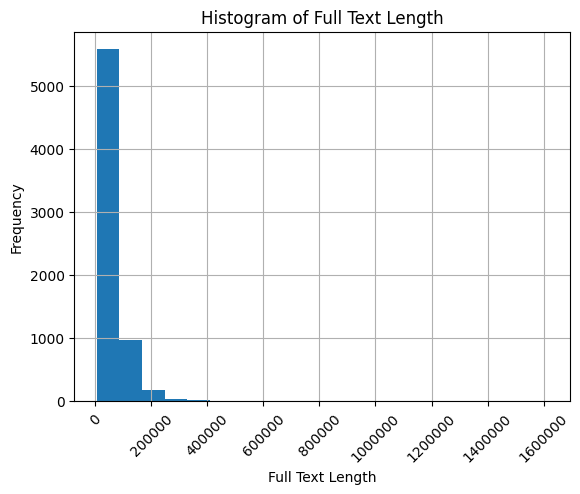

In [29]:
text_lengths = [len(item['text']) for item in full_text_citing]
plt.hist(text_lengths, bins=20)
plt.xlabel('Full Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Full Text Length')
plt.grid(True)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)
plt.show()


In [36]:
#TOOD: Full Text TF_IDF
full_text_citing = create_corpus(json_citing_train, 'fulltext')
full_text_nonciting = create_corpus(json_nonciting, 'fulltext')

print("Sample citing fulltext:", full_text_citing[:2])

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)

tfidf_citing, tfidf_nonciting = create_tfidf_matrix(full_text_citing, full_text_nonciting, tfidf_vectorizer)

print("Shape of citing TF-IDF matrix: ",tfidf_citing.shape)
print("Shape of cited TF-IDF matrix: ",tfidf_nonciting.shape)

Sample citing fulltext: [{'id': '3650293A1', 'text': 'DEVICE FOR CONTROLLING THE BRAKING OF A TRAILER The device (1) for controlling the braking of a trailer, comprises: one control line (2) connectable to a source of a work fluid at a first pressure; a braking line (3) connectable to the service braking system (4) of the trailer and communicating with the control line (2); one additional line (5) connectable to a source of a work fluid at a second pressure; one emergency line (6) connectable to the additional line (5) and connectable to the emergency and/or parking brake (7) of the trailer of the type of a hydraulically released spring brake; one discharge line (8) of the work fluid communicating with a collection tank (9); first valve means operable between a braking position, wherein the additional line (5) is isolated from the discharge line (8), and an emergency position, wherein the additional line (5) is communicating with the discharge line (8); second valve means (17) position

TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Size of vocabulary: 10000
Shape of citing TF-IDF matrix: (6831, 10000)
Shape of cited TF-IDF matrix: (16837, 10000)


In [38]:
cosine_similarities = linear_kernel(tfidf_citing, tfidf_nonciting)

k = 100
top_k_rank = top_k_ranks(full_text_citing, full_text_nonciting, cosine_similarities, k=k)

true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)

mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)

recall_at_10_fulltext = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_fulltext = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_fulltext = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_fulltext = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_fulltext, 4))
print("Recall at 20:", round(recall_at_20_fulltext, 4))
print("Recall at 50:", round(recall_at_50_fulltext, 4))
print("Recall at 100:", round(recall_at_100_fulltext, 4))
print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.5449
Recall at 20: 0.6431
Recall at 50: 0.7632
Recall at 100: 0.8432
Mean ranking: 28.4859
Mean average precision: 0.3343
Number of patents measured: 6831
Number of patents not in the citation: 0


# 3.0 BM-25

## 3.1 Initialize BM25 Class

In [39]:
class BM25Score:
    """BM25 scoring algorithm implementation for document ranking."""

    def __init__(self, vectorized_docs, k1=1.5, b=0.75):
        """
        Initialize the BM25Score object.

        Parameters:
        - vectorized_docs (scipy.sparse.csr_matrix): Sparse matrix of word counts representing vectorized documents.
        - k1 (float, optional): Tuning parameter that controls term frequency normalization. Default is 1.5.
        - b (float, optional): Tuning parameter that controls the impact of document length normalization. Default is 0.75.
        """
        self.k1 = k1
        self.b = b
        self.vectorized_docs = vectorized_docs

    def fit(self, vectorized_queries=None, query_ids=None, args=None):
        """
        Fit the BM25 model to the provided vectorized documents.

        Parameters:
        - vectorized_queries (scipy.sparse.csr_matrix, optional): Sparse matrix of word counts representing vectorized queries. Default is None.
        - query_ids (list, optional): List of query IDs. Default is None.
        - args (dict, optional): Additional arguments for grid search integration. Default is None.

        Returns:
        - self (BM25Score): Returns the instance of the BM25Score object after fitting.
        """
        self.n_d = self.vectorized_docs.sum(axis=1).reshape(-1, 1).A
        self.avgdl = np.mean(self.n_d)
        self.n_docs = self.vectorized_docs.shape[0]

        self.nq = np.sum(self.vectorized_docs > 0, axis=0).reshape(1, -1)
        self.idf = np.log(((self.n_docs - self.nq + 0.5) / (self.nq + 0.5)) + 1).A
        return self

    def predict(self, vectorized_queries):
        """
        Predict relevance scores for the given vectorized queries.

        Parameters:
        - vectorized_queries (scipy.sparse.csr_matrix): Sparse matrix of word counts representing vectorized queries.

        Returns:
        - scores (numpy.ndarray): Array of relevance scores for the queries.
        """
        idx_tokens = np.argwhere(vectorized_queries.sum(axis=0) > 0).reshape(-1)
        vectorized_queries = vectorized_queries[:, idx_tokens]
        vectorized_docs = self.vectorized_docs[:, idx_tokens].toarray()
        idf = self.idf[:, idx_tokens]

        scores = idf * (
            (vectorized_docs * (self.k1 + 1)) / \
            (
                vectorized_docs + \
                self.k1 * (1 - self.b + self.b * (self.n_d / self.avgdl))
            )
        )

        return (vectorized_queries > 0).astype(np.int8) @ scores.T

def create_bm25_matrix(citing_dataset, nonciting_dataset, vectorizer=CountVectorizer()):
    """
    Creates BM25 similarity scores for the given citing and non-citing datasets based on the specified text column.

    Parameters:
    citing_dataset (json): DataFrame containing citing patents.
    nonciting_dataset (json): DataFrame containing non-citing patents.
    vectorizer (CountVectorizer, optional): CountVectorizer object for vectorizing text data.
                                            Defaults to CountVectorizer().

    Returns:
    array: Similarity scores matrix between citing and non-citing patents.
    """
    all_text_citing = [patent['text'] for patent in citing_dataset]
    all_text_nonciting = [patent['text'] for patent in nonciting_dataset]

    # Vectorizing descriptions
    print("Vectorizing descriptions...")
    vectorizer.fit(all_text_citing + all_text_nonciting)
    count_matrix_citing = vectorizer.transform(all_text_citing)
    count_matrix_nonciting = vectorizer.transform(all_text_nonciting)

    # Using BM25 scoring
    print("Computing BM25 scores...")
    bm25 = BM25Score(count_matrix_nonciting)
    bm25.fit()
    bm25_scores = bm25.predict(count_matrix_citing)

    return bm25_scores

## 3.2 'Title' BM25

In [ ]:
# Create BM25 similarity scores
bm25_scores = create_bm25_matrix(title_citing_train, title_nonciting)

print(f"Shape of BM25 scores matrix: {bm25_scores.shape}")

Vectorizing descriptions...
Computing BM25 scores...


In [35]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(title_citing_train, title_nonciting, bm25_scores, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_titles_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_titles_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_titles_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_titles_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_titles_bm25, 4))
print("Recall at 20:", round(recall_at_20_titles_bm25, 4))
print("Recall at 50:", round(recall_at_50_titles_bm25, 4))
print("Recall at 100:", round(recall_at_100_titles_bm25, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.2687
Recall at 20: 0.3297
Recall at 50: 0.4115
Recall at 100: 0.4719
Mean ranking: 61.6857
Mean average precision: 0.1655
Number of patents measured: 6831
Number of patents not in the citation: 0


## 3.3 'Claims1' BM25

In [36]:
print(f"Number of citing: {len(claim1_citing)}")
print(f"Number of nonciting: {len(claim1_nonciting)}")
print(f"Sum: {len(claim1_citing) + len(claim1_nonciting)}")

Number of citing: 6831
Number of nonciting: 16834
Sum: 23665


In [ ]:
# Create BM25 similarity scores
bm25_scores = create_bm25_matrix(claim1_citing, claim1_nonciting)

print(f"Shape of BM25 scores matrix: {bm25_scores.shape}")

Vectorizing descriptions...
Computing BM25 scores...


In [ ]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(claim1_citing, claim1_nonciting, bm25_scores, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)

mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_claim1_bm25, 4))
print("Recall at 20:", round(recall_at_20_claim1_bm25, 4))
print("Recall at 50:", round(recall_at_50_claim1_bm25, 4))
print("Recall at 100:", round(recall_at_100_claim1_bm25, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

In [ ]:
len(true_labels)

In [ ]:
len(predicted_labels[0])

100

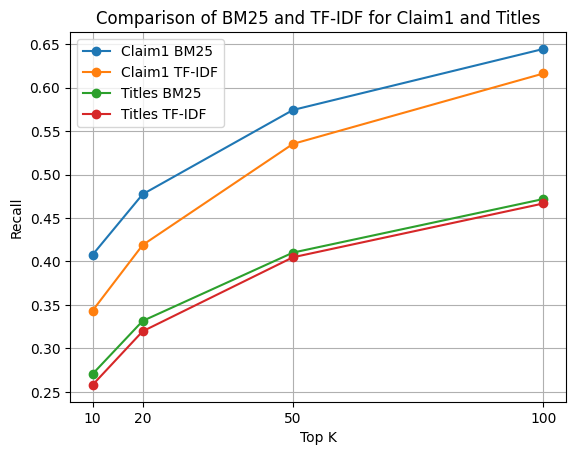

In [ ]:
k_values = [10, 20, 50, 100]

plt.plot(k_values, [recall_at_10_claim1_bm25, recall_at_20_claim1_bm25, recall_at_50_claim1_bm25, recall_at_100_claim1_bm25], label='Claim1 BM25', marker='o')
plt.plot(k_values, [recall_at_10_claim1_tfidf, recall_at_20_claim1_tfidf, recall_at_50_claim1_tfidf, recall_at_100_claim1_tfidf], label='Claim1 TF-IDF', marker='o')
plt.plot(k_values, [recall_at_10_titles_bm25, recall_at_20_titles_bm25, recall_at_50_titles_bm25, recall_at_100_titles_bm25], label='Titles BM25', marker='o')
plt.plot(k_values, [recall_at_10_titles_tfidf, recall_at_20_titles_tfidf, recall_at_50_titles_tfidf, recall_at_100_titles_tfidf], label='Titles TF-IDF', marker='o')

plt.xlabel('Top K')
plt.ylabel('Recall')
plt.title('Comparison of BM25 and TF-IDF for Claim1 and Titles')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

# 4.0 Get Test Predictions for CodaBench

In [ ]:
# Create BM25 similarity scores
bm25_scores = create_bm25_matrix(title_citing_test, title_nonciting)
top_k_rank = top_k_ranks(title_citing_test, title_nonciting, bm25_scores, k=k)

print(f"Shape of BM25 scores matrix: {bm25_scores.shape}")

Vectorizing descriptions...
Computing BM25 scores...
Shape of BM25 scores matrix: (1000, 16837)


In [ ]:
with open('prediction1.json', 'w') as f:
    json.dump(top_k_rank, f)